**<h1><center>Product Recommendation System (Amazon.com)</center></h1>**

Product recommendation systems are types of software that use data analysis and machine learning techniques to suggest products to customers based on their interests, past purchases, and browsing history. These systems can be found on e-commerce websites, such as Amazon.com, and are designed to provide personalised recommendations to users in real-time. Recommendation systems work by analysing vast amounts of data, such as user behaviour, product attributes, and transaction history. Based on this data, the system generates recommendations that are relevant to the user's interests and preferences. For example, if a user has previously purchased a book on a specific topic, the recommendation system may suggest other books on the same topic, or related topics.

The Amazon Review Data (2018) dataset can be utilised to train a product recommendation system that offers personalised product suggestions to users based on their purchase history, as well as the satisfaction levels of other users who have reviewed and rated products on the platform. However, since the dataset is vast, it is crucial to carefully analyse and select the relevant features that will effectively contribute to the product recommendation system, in order to avoid both overfitting and underfitting of the machine learning model.

## What Is Our Approach?

Similar to our approach in conducting Exploratory Data Analysis (EDA) on the Amazon Review Data (2018) dataset **Amazon Review Data (2018) Analysis.ipynb, 1-38)**, we employed an inferential statistical method for training our product recommendation model. The rationale for using a sample to make inferences about the entire population is to minimise the computational burden associated with processing the complete dataset, which is often impractical for a single machine. While deep learning typically requires large amounts of data, machine learning can be effectively used to develop robust training methodologies even with small datasets. This is particularly useful for hypothesis-driven research, which is our primary objective with the product recommendation system. **(Vabalas et al., 2019)** In any case, it is important to note that any dataset is essentially a subset of a larger population.

To ensure the accuracy of our results, it is crucial to carefully analyse and mitigate potential biases in the data. This is particularly important in machine learning, which is sensitive to biases that can result in skewed performance estimates. To address this issue, we will apply the stratified random sampling approach we discussed earlier to extract a representative sample of 10,000,000 records from the population while maintaining the same product distribution as in the original dataset. **(compress.py, 1-61)** Since the sample size is quite large, we have compressed it into an Apache Parquet file format, which reduces the dataset's size by over 90%.

In [1]:
#   Importing the required libraries/modules.

from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import *
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt
import seaborn as sns

#### Reading the Required Data:

Firstly, our objective is to create a **SparkSession** instance that will connect to MongoDB using the MongoDB Connector for Spark. Next, we will retrieve the compressed sample data from the previously stored Apache Parquet file, which will serve as the basis for feature engineering and training of our machine learning model. To ensure a smooth and efficient process given the large amount of data involved, we have implemented additional configuration options for Apache Spark, such as using a serialiser to encode the data before transferring or storing it, thereby enhancing the performance of the framework.

In [2]:
#   Creating an instance of a SparkSession object and connecting it to MongoDB.

spark=SparkSession \
    .builder \
    .appName("ProductRecommendationModel") \
    .master("local") \
    .config("spark.mongodb.input.uri", "mongodb://localhost:27017/") \
    .config("spark.mongodb.output.uri", "mongodb://localhost:27017/") \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.memory", "8g") \
    .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.12:3.0.1") \
    .config("spark.sql.autoBroadcastJoinThreshold", "-1") \
    .config("spark.storage.memoryFraction", "1") \
    .config("spark.rdd.compress", "true") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .config("spark.kryoserializer.buffer.max", "1g") \
    .config("spark.sql.parquet.compression.codec", "gzip") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR") #   Overriding the default log level.

#   Reading the sample data from the Apache Parquet file as a collection into the Spark DataFrame.

dataframe=spark.read.parquet("../data/sample.parquet/part-00000-32a46cff-973b-4505-845b-28dd26c7d2dc-c000.gz.parquet",
                                header=True, inferSchema=True)

23/05/10 09:58:38 WARN Utils: Your hostname, Huzaifas-MacBook-Pro-2.local resolves to a loopback address: 127.0.0.1; using 192.168.100.13 instead (on interface en0)
23/05/10 09:58:38 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Ivy Default Cache set to: /Users/huzaifa/.ivy2/cache
The jars for the packages stored in: /Users/huzaifa/.ivy2/jars
org.mongodb.spark#mongo-spark-connector_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-1330d800-7acd-4ebe-9a93-053e7b6109f4;1.0
	confs: [default]


:: loading settings :: url = jar:file:/Users/huzaifa/Library/Python/3.9/lib/python/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


	found org.mongodb.spark#mongo-spark-connector_2.12;3.0.1 in central
	found org.mongodb#mongodb-driver-sync;4.0.5 in central
	found org.mongodb#bson;4.0.5 in central
	found org.mongodb#mongodb-driver-core;4.0.5 in central
:: resolution report :: resolve 108ms :: artifacts dl 4ms
	:: modules in use:
	org.mongodb#bson;4.0.5 from central in [default]
	org.mongodb#mongodb-driver-core;4.0.5 from central in [default]
	org.mongodb#mongodb-driver-sync;4.0.5 from central in [default]
	org.mongodb.spark#mongo-spark-connector_2.12;3.0.1 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   4   |   0   |   0   |   0   ||   4   |   0   |
	---------------------------------------------------------------------
:: retrieving ::

In [3]:
dataframe.show()

+----------+--------------+-------+
|      asin|    reviewerID|overall|
+----------+--------------+-------+
|B01GW8X7N0|A1Y9D5IBLKHJPA|    5.0|
|B00V2L5JRA|A3OTLQVHWE5YVU|    4.0|
|1910747432| AQETPPD44YLRE|    5.0|
|B00D84GA40|A2HDZ8FG4MW4G0|    1.0|
|B01A4S5ZDY| AI8STZ6N2AZCN|    5.0|
|B01FSTHW5I| AILJMBPIBYPY5|    5.0|
|B00NCJ4FSO|A3VU9YWDZRKAHI|    1.0|
|B0006SW6YY|A15MANA5GSYA3M|    5.0|
|0316198846|A36D0Y0E2LI7DA|    5.0|
|B002ZNJS0I|A284SEFYENMKYB|    4.0|
|B018RFOCQW|A15DKQZ248W3P2|    1.0|
|B00U6VUY6I|A2LAXO9GT646MC|    2.0|
|B00AHED2FE|A1AX2LORJKLDOX|    3.0|
|B005LAII4E|A104KDXA8NQOUV|    4.0|
|B00BLWF38K|A17KJ96VQHZDJO|    4.0|
|1592173357|A3J9XQ3C6OV53X|    5.0|
|B01964SMTQ|A1HMVUJ7NSXIQN|    4.0|
|B00GXYI0E0|A2X2M0YNNLKEEA|    5.0|
|B00P19E7K4|A12DCYXZGFR7NW|    5.0|
|B0014XOS64|A1Y51PEYQPPZ8X|    1.0|
+----------+--------------+-------+
only showing top 20 rows



#### Feature Engineering:

Feature engineering is the process of selecting, transforming, and creating input variables, also known as features, for use in machine learning models. It is a critical step in building accurate and effective models because the quality and relevance of the features used significantly impact the performance of the model. The goal of feature engineering is to create a set of features that represent the underlying patterns in the data and capture the relevant information necessary for the model to make accurate predictions.

Selecting the appropriate set of features for training the machine learning model is crucial, as well-engineered features can streamline the model's complexity, enhance its precision, and render it more comprehensible. Therefore, it is imperative that we identify and decide which features should be employed for training the model. We utilised our Apache Parquet file to store a limited set of attributes, namely **asin**, **reviewerID**, and **overall**, to create a product recommendation system. The rationale behind selecting only these attributes was to implement collaborative filtering, which enables us to leverage similarities between users and items concurrently to generate recommendations. Collaborative filtering models can suggest items to a particular user based on the preferences of similar users, resulting in unexpected and exciting recommendations. Additionally, the embeddings can be learned automatically without the need for manual feature engineering. **(Google, *Collaborative Filtering*)**

In [4]:
dataframe.printSchema()

root
 |-- asin: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- overall: double (nullable = true)



In [5]:
dataframe.dtypes

[('asin', 'string'), ('reviewerID', 'string'), ('overall', 'double')]

To enhance the parallelism and resource utilisation during computation, we will be partitioning the Spark DataFrame into 100 partitions. This process involves reshuffling the data across the partitions, ensuring that each partition has an approximately equal amount of data. The primary objective of repartitioning the Spark DataFrame is to distribute the workload more evenly across available cores, thus leading to improved efficiency and faster processing of the data. By increasing the number of partitions, we can enhance the parallelism of subsequent operations performed on the Spark DataFrame.

In [6]:
dataframe=dataframe.repartition(100)
dataframe.rdd.getNumPartitions()

100

##### **• Transforming categorical features into numerical features:**

Collaborative filtering works by finding similarities between users or items based on their attributes or preferences, and then using these similarities to make recommendations. To find these similarities, the attributes or preferences of users or items need to be represented numerically. Therefore, categorical features, which represent attributes or preferences using discrete categories, are often converted into numerical features before being used in collaborative filtering models.

Therefore, we need to convert the asin and reviewerID columns into numerical values before moving forward. For this, we will be using string indexing, which is involves assigning a unique numerical value to each category or level of the categorical feature. It is a simple and effective way to convert categorical features into numerical features. However, it is important to keep in mind that string indexing has its own limitations. One limitation is that it assumes an arbitrary order of the categories, which may not reflect the true relationships between them. Another limitation is that it can result in high-dimensional data when applied to categorical features with a large number of categories, which can lead to computational and performance issues.

In [7]:
indexers=[StringIndexer(inputCol=column, outputCol=column+"_index").fit(dataframe) for column in list(set(dataframe.columns)-set(["overall"]))]
pipeline=Pipeline(stages=indexers)
dataframe=pipeline.fit(dataframe).transform(dataframe)
dataframe.show()

+----------+--------------+-------+----------+----------------+
|      asin|    reviewerID|overall|asin_index|reviewerID_index|
+----------+--------------+-------+----------+----------------+
|B0142ITWS6|  AKH4YZU8UKGI|    4.0| 2825539.0|       6133100.0|
|B001KN354O|A1CKXN2A5U4FBZ|    4.0| 1759395.0|        358910.0|
|B00005O0I2|A2P5KJLAVF7KG4|    5.0|   19120.0|       1095142.0|
|B01H6RK3RO|A1QQP17ZJ4Y482|    5.0|  706093.0|       2629495.0|
|B00J68U2W8|A24GPXRSCWKKEG|    5.0|  462486.0|        228755.0|
|B00ZTP2LJO|A1MRFGO1DQRPBE|    4.0|   10598.0|        820257.0|
|B005AT3D82|A3TWXCUPUEJFRN|    3.0| 1942551.0|       5431387.0|
|B0046GIWXG| A14CX609CUHIC|    5.0|  154791.0|       1797712.0|
|B008PPPRUK|A1BL8K3H5HPDKZ|    5.0|   13854.0|        356552.0|
|B00NTOQ02G| AHSA30LSC7294|    5.0| 1047374.0|       1502974.0|
|1496030001| AW4CS291NCW0E|    5.0|  319557.0|        115020.0|
|034552019X|A1NTLIR8Y103VA|    4.0|  147626.0|       2521235.0|
|B0132TLTDM|A1QC1HQHXR8RPH|    5.0| 2810

Applying string indexing to the categorical columns enables their conversion into an integer format, which is not mandatory but could potentially reduce the storage requirements of the Spark DataFrame and enhance its computational efficiency.

In [8]:
dataframe=dataframe.withColumn("reviewerID_index", dataframe["reviewerID_index"].cast(IntegerType()))
dataframe=dataframe.withColumn("asin_index", dataframe["asin_index"].cast(IntegerType()))
dataframe=dataframe.withColumn("overall", dataframe["overall"].cast(IntegerType()))
dataframe.show()

+----------+--------------+-------+----------+----------------+
|      asin|    reviewerID|overall|asin_index|reviewerID_index|
+----------+--------------+-------+----------+----------------+
|B0142ITWS6|  AKH4YZU8UKGI|      4|   2825539|         6133100|
|B001KN354O|A1CKXN2A5U4FBZ|      4|   1759395|          358910|
|B00005O0I2|A2P5KJLAVF7KG4|      5|     19120|         1095142|
|B01H6RK3RO|A1QQP17ZJ4Y482|      5|    706093|         2629495|
|B00J68U2W8|A24GPXRSCWKKEG|      5|    462486|          228755|
|B00ZTP2LJO|A1MRFGO1DQRPBE|      4|     10598|          820257|
|B005AT3D82|A3TWXCUPUEJFRN|      3|   1942551|         5431387|
|B0046GIWXG| A14CX609CUHIC|      5|    154791|         1797712|
|B008PPPRUK|A1BL8K3H5HPDKZ|      5|     13854|          356552|
|B00NTOQ02G| AHSA30LSC7294|      5|   1047374|         1502974|
|1496030001| AW4CS291NCW0E|      5|    319557|          115020|
|034552019X|A1NTLIR8Y103VA|      4|    147626|         2521235|
|B0132TLTDM|A1QC1HQHXR8RPH|      5|   28

##### **• Performing data balancing:**

Data balancing, also known as class balancing, is the process of adjusting the proportion of observations in each class or category of a dataset to mitigate any imbalances that may exist. In machine learning, class imbalance occurs when the number of observations in each class is significantly different. This can negatively impact the performance of the model, as the model may become biased towards the majority class and perform poorly on the minority class.

Given that product ratings constitute our primary class of interest in training the machine learning model using collaborative filtering, it is imperative to confirm the absence of any data imbalance and address it proactively before commencing the training process. Data balancing can improve the accuracy and performance of machine learning models, particularly in applications where the minority class is of high importance.

In [9]:
distribution=dataframe.groupBy("overall").count().toPandas()
distribution

,overall,count
0,1,675334
1,3,744607
2,5,6532659
3,4,1613141
4,2,434259


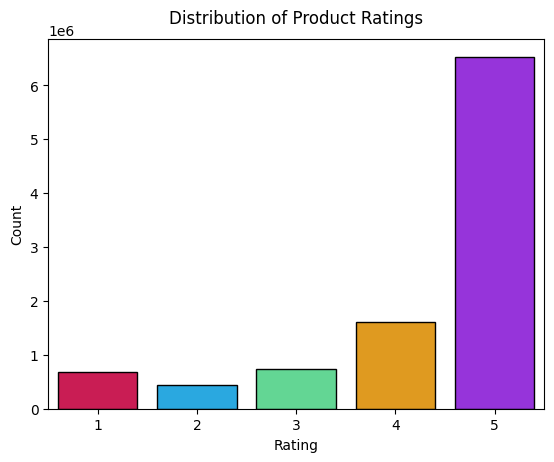

In [10]:
#   Plotting a bar plot of the distribution of the product ratings.

sns.barplot(x="overall", y="count", data=distribution, palette=["#E60049", "#0BB4FF", "#50E991", "#FFA300", "#9B19F5"], edgecolor="black")
plt.title("Distribution of Product Ratings", y=1.02)
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

In our scenario, the dataset exhibits significant imbalance, with 65% of the ratings being five-star ones. Since the product ratings contain four additional classes that are equally significant as the majority class, it is crucial to balance the data to prevent any potential biases that may arise in the future. Upsampling and downsampling are potential techniques that can be employed to tackle this issue.

In our situation, we have decided to opt for undersampling as opposed to upsampling, as the latter may introduce potential biases by augmenting the data and result in increased computational expenses — neither of which is desirable. Undersampling involves reducing the number of observations in the majority class to match the number of observations in the minority class. This is typically done by randomly selecting a subset of the majority class observations equal to the number of observations in the minority class.

In [11]:
majority_dataframe=dataframe.filter(col("overall")==5.0)
minority_dataframe=dataframe.filter(col("overall")!=5.0)
ratio=majority_dataframe.count()/minority_dataframe.count()
ratio=int(ratio)+1
print("Ratio: {}".format(ratio))

Ratio: 2


In [12]:
sampled_majority_dataframe=majority_dataframe.sample(False, 1/ratio)
combined_dataframe=sampled_majority_dataframe.unionAll(minority_dataframe)
dataframe=combined_dataframe
dataframe.show()

+----------+--------------+-------+----------+----------------+
|      asin|    reviewerID|overall|asin_index|reviewerID_index|
+----------+--------------+-------+----------+----------------+
|B00J68U2W8|A24GPXRSCWKKEG|      5|    462486|          228755|
|B0046GIWXG| A14CX609CUHIC|      5|    154791|         1797712|
|B008PPPRUK|A1BL8K3H5HPDKZ|      5|     13854|          356552|
|B00NTOQ02G| AHSA30LSC7294|      5|   1047374|         1502974|
|1496030001| AW4CS291NCW0E|      5|    319557|          115020|
|B0132TLTDM|A1QC1HQHXR8RPH|      5|   2810364|           84873|
|B00UXRSDF4|A1C27KXH4DOUC2|      5|    299103|          743436|
|B00PQXVP0A| A3698QX2HGP16|      5|   1057513|           16559|
|1477595422| AG0BO6FBIZAY9|      5|   1392639|         5966747|
|B00FFADO8A|A3D21TCRZBLA7L|      5|       423|         4803201|
|B000NSIRRW|A1HU1FY622EL36|      5|   1663273|         2298109|
|B00WRZWBF8|A3P48NQKUVX6MV|      5|     97561|         5252867|
|B00065FWR0|A12251YR1O3JJP|      5|     

In [13]:
balanced_distribution=dataframe.groupBy("overall").count().toPandas()
balanced_distribution

,overall,count
0,5,3265893
1,1,675334
2,3,744607
3,4,1613141
4,2,434259


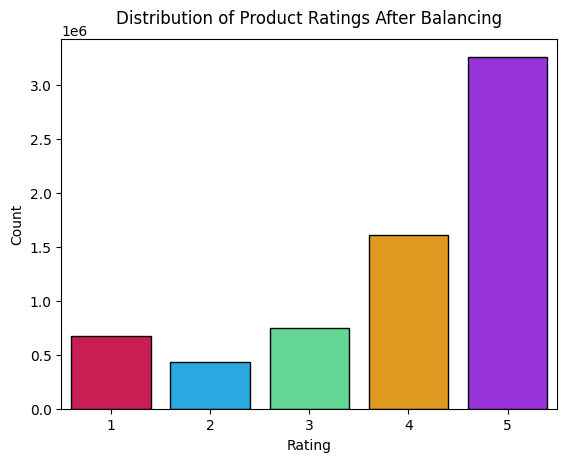

In [14]:
#   Plotting a bar plot of the distribution of the product ratings after balancing.

sns.barplot(x="overall", y="count", data=balanced_distribution, palette=["#E60049", "#0BB4FF", "#50E991", "#FFA300", "#9B19F5"], edgecolor="black")
plt.title("Distribution of Product Ratings After Balancing", y=1.02)
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

It is worth noting that undersampling can lead to the loss of valuable information. Nevertheless, as our approach relies on using sample data to estimate population parameters, we can discard a certain amount of information and still maintain the generalisability of the machine learning model. However, if we were to utilise all the unique products and users in constructing the product recommendation system, it would not be prudent to dispose of important information. In such a case, we would have opted for a non-inferential statistical approach from the outset.

With our feature engineering now complete, we can progress to train the machine learning model for the product recommendation system. However, before proceeding, we must store the present state of the data in a convenient and efficient manner for future reference. To begin with, we will be caching the Spark DataFrame, which can significantly expedite computations that necessitate multiple passes over the data, such as iterative algorithms or complex data manipulations. Caching a Spark DataFrame involves storing it in memory or on disk (depending on the size of the Spark DataFrame and the available memory) and enables swift access without requiring recalculation.

In [15]:
dataframe.cache()

DataFrame[asin: string, reviewerID: string, overall: int, asin_index: int, reviewerID_index: int]

In addition, we will store the transformed data as a collection in our MongoDB database to enable permanent access. This is necessary for evaluating the outcomes of the product recommendation system, as string indexed data is not very informative and holds no significance outside the technical workflow.

In [16]:
#   Writing the Spark DataFrame into the MongoDB database as a collection.

database="amazon_review_data"
collection="features"
dataframe.select("asin", "reviewerID", "overall", "asin_index", "reviewerID_index").write \
    .format("com.mongodb.spark.sql.DefaultSource") \
    .option("uri", "mongodb://localhost:27017/"+database+"."+collection) \
    .option("replaceDocument", "false") \
    .option("partitioner", "MongoSinglePartitioner") \
    .option("partitionKey", "asin") \
    .save()

## Product Recommendation Model:

Moving on to the training of the product recommendation model, our initial step is to randomly partition the data into training and testing sets. The training set will be used for training the machine learning model, while the testing set will be used to assess its performance. In keeping with standard practice, we have allocated 80% of the total sample data to the training set, with the remaining 20% reserved for testing.

In [17]:
(train, test)=dataframe.randomSplit([0.8, 0.2])

### What Is the Alternating Least Squares (ALS) Algorithm?

Alternating Least Squares (ALS) is a collaborative filtering algorithm used for developing product recommendation systems. The algorithm aims to learn the latent or hidden factors that influence user-item interactions, by decomposing the user-item rating matrix into two low-rank matrices representing the user and item latent factors.

Alternating Least Squares (ALS) works iteratively, alternating between fixing one set of latent factors and solving for the other using a least-squares optimisation algorithm. In particular, in each iteration, the algorithm fixes the item latent factors and solves for the user latent factors using least-squares optimisation, and then fixes the user latent factors and solves for the item latent factors using least-squares optimisation.

### Why the Alternating Least Squares (ALS) Algorithm?

Alternating Least Squares (ALS) has several advantages for product recommendation systems. It is scalable and computationally efficient, particularly for large and sparse datasets. It can handle implicit feedback data, where user-item interactions are only known to exist or not exist, and not their specific ratings. It can also handle missing data, where not all users have rated all items. Additionally, Alternating Least Squares (ALS) can provide item recommendations in real-time, making it suitable for online recommendation systems.

- **rank:** The number of latent factors or features to be learned in the Alternating Least Squares (ALS) model — this hyper-parameter controls the complexity of the model and can affect its accuracy and generalisation ability. In our instance, by setting `rank=5`, we are instructing the model to learn five latent factors that are common to both users and items.

- **regParam:** The regularisation parameter for controlling overfitting in the Alternating Least Squares (ALS) model — this hyper-parameter adds a penalty term to the least-squares optimisation problem to prevent overfitting to the training data. By setting `regParam=0.5` in our case, we are indicating that a reasonable degree of regularisation should be employed.

- **nonnegative:** This hyper-parameter pecifies whether the Alternating Least Squares (ALS) model should enforce non-negativity constraints on the learned latent factors. In our case, the setting `nonnegative=True` signifies that the learned latent factors must be non-negative.

- **coldStartStrategy:** This hyper-parameter specifies how to handle new users or items that were not present in the training data. In our scenario, `coldStartStrategy="drop"` indicates that any new users or items in the test data will be excluded or dropped.

Finally, we have also instructed the Alternating Least Squares (ALS) algorithm to store both the intermediate data and trained machine learning model in memory and on disk.

In [18]:
als=ALS(rank=5, maxIter=30, regParam=0.5, userCol="reviewerID_index", itemCol="asin_index", ratingCol="overall", nonnegative=True,
            coldStartStrategy="drop", intermediateStorageLevel="MEMORY_AND_DISK_2", finalStorageLevel="MEMORY_AND_DISK_2")
model=als.fit(train)

After training the machine learning model, we can appraise its performance by generating predictions on the testing instance.

In [19]:
predictions=model.transform(test)
predictions.show()

+----------+--------------+-------+----------+----------------+----------+
|      asin|    reviewerID|overall|asin_index|reviewerID_index|prediction|
+----------+--------------+-------+----------+----------------+----------+
|0297859382|A25KFV4A87ZEZ0|      4|         1|           24747| 3.3340242|
|0297859382|A3CLMS1H8D2XJN|      1|         1|           35389| 1.7777038|
|0297859382| ATXWSVJBRSYZA|      2|         1|           38697| 3.3738701|
|0297859382|A1Y3LI7ME8EKYR|      4|         1|           59838| 3.5257664|
|0297859382|A3NPCJJDWAN9IW|      3|         1|           70310|  3.867756|
|0297859382|A16QWJNSAWFCQ4|      5|         1|           79186| 3.8521726|
|0297859382|A1UGHDQHQEWSL6|      4|         1|          131985| 1.7314649|
|0297859382|A27JIFOERJY44W|      3|         1|          138816| 2.7881374|
|0297859382|A2IWNSA9WTHSIM|      3|         1|          144675| 3.5433397|
|0297859382| AKRYJH06IZYMK|      4|         1|          178860|  3.331997|
|0297859382|A15L0TK7WIQVU

Lastly, we can gauge the effectiveness of the trained machine learning model by computing the Root Mean Square Error (RMSE) using the predictions generated by the Alternating Least Squares (ALS) algorithm. Root Mean Square Error (RMSE) is a common metric used to assess the accuracy of regression models, such as those employed in collaborative filtering-based recommendation systems. It quantifies the average magnitude of the differences between predicted and actual values and provides a single value for model evaluation. The Root Mean Square Error (RMSE) value ranges from zero to infinity, with lower values indicating better model performance.

In [21]:
evaluator=RegressionEvaluator(metricName="rmse", labelCol="overall", predictionCol="prediction")
rmse=evaluator.evaluate(predictions)
print("Root Mean Square Error (RMSE): {}".format(rmse))

Root Mean Square Error (RMSE): 2.093642524258529


In our case, the Root Mean Square Error (RMSE) seems to be approximately 2.09, which means that on average, the Alternating Least Squares (ALS) algorithm's predictions deviate from the actual values by approximately 2.09 on a scale of one to five. Hence, this value can be regarded as somewhat high. One way to enhance model performance and reduce the degree of error is by leveraging hyper-parameter tuning techniques like grid search to identify the best combination of hyper-parameters for the model. Nonetheless, grid search involves substantial computational and time costs that are not practical in our situation.

Finally, we will save the trained machine learning model for our product recommendation system.

In [24]:
model.save("../model/product_recommendation_model")

In [ ]:
spark.stop()    #   Stopping the SparkSession object.

### References:

- Vabalas, A. et al. (2019) *‘Machine learning algorithm validation with a limited sample size’*, PLOS ONE, 14(11). doi:10.1371/journal.pone.0224365.

- *Collaborative Filtering* (no date) *Google*. Available at: https://developers.google.com/machine-learning/recommendation/collaborative/basics (Accessed: 11 May 2023). 